# 🔬 Notebook 02: Model Architecture Comparison

## Objective
Compare three architectures with **identical training configurations** to make a data-driven architecture selection.

## Candidates
| Model | Type | Parameters | Hypothesis |
|-------|------|------------|------------|
| ResNet-50 | CNN | 25.6M | Strong baseline, local features |
| EfficientNet-B2 | CNN | 9.2M | Efficient, compound scaling |
| ViT-Small | Transformer | 21.7M | Global attention for fine-grained |

## Methodology
- **Fair comparison**: Same optimizer, LR, epochs, augmentations
- **No cherry-picking**: Winner selected purely on test accuracy
- **Reproducibility**: Fixed seeds (42)

## Key Question
> Does global attention (ViT) outperform local convolutions (CNNs) on fine-grained flower classification?

## Outputs
- Trained model weights for all 3 architectures
- `model_comparison.json`: Accuracy and training metrics

In [1]:
# ============================================================
# 🌸 Oxford 102 Flowers Classification
# Notebook 02: Fair Model Comparison
# ============================================================
"""
Methodology:
1. Train 3 architectures with IDENTICAL strategy (fair comparison)
   - ResNet-50 (CNN baseline)
   - EfficientNet-B2 (Efficient CNN)
   - ViT-Small (Vision Transformer)
   
2. Same training config for all:
   - Full fine-tuning (no frozen layers)
   - Same epochs, optimizer, scheduler
   - Same augmentations
   
3. Pick the winner based on test accuracy
"""

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q timm albumentations
    from google.colab import drive
    drive.mount('/content/drive')
    DATA_ROOT = "./data"
    ARTIFACTS = "/content/drive/MyDrive/flowers-cv"
else:
    DATA_ROOT = "../data"
    ARTIFACTS = "../artifacts"

import os
os.makedirs(f"{ARTIFACTS}/figures", exist_ok=True)
os.makedirs(f"{ARTIFACTS}/models", exist_ok=True)

print("✅ Environment ready")

✅ Environment ready


In [2]:
# Cell: Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import timm
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.datasets import Flowers102
from PIL import Image
from tqdm import tqdm
import time
import json
import warnings
warnings.filterwarnings('ignore')

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🖥️  Device: {device}")
if device.type == 'cuda':
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   Memory: {torch.cuda.get_device_properties(0).total_memory/1e9:.1f} GB")

🖥️  Device: cuda
   GPU: NVIDIA GeForce RTX 4060 Laptop GPU
   Memory: 8.6 GB


In [3]:
# Cell: Reproducibility
def seed_everything(seed=42):
    """Set all random seeds for reproducibility"""
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)
print("✅ Random seeds set for reproducibility")

✅ Random seeds set for reproducibility


In [4]:
# Cell: Dataset Class with Albumentations
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

train_transform = A.Compose([
    A.RandomResizedCrop(size=(224, 224), scale=(0.8, 1.0)),
    A.HorizontalFlip(p=0.5),
    A.Affine(rotate=(-30, 30), p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.3, hue=0.1, p=0.5),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.3),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

eval_transform = A.Compose([
    A.Resize(256, 256),
    A.CenterCrop(224, 224),
    A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
    ToTensorV2()
])

class FlowersDataset(Dataset):
    def __init__(self, root, split, transform=None):
        self.data = Flowers102(root=root, split=split, download=True)
        self.transform = transform
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = np.array(img)
        
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img, label

# Create datasets
train_dataset = FlowersDataset(DATA_ROOT, "train", train_transform)
val_dataset = FlowersDataset(DATA_ROOT, "val", eval_transform)
test_dataset = FlowersDataset(DATA_ROOT, "test", eval_transform)

# Create dataloaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=4, pin_memory=True)

print(f"✅ Datasets loaded")
print(f"   Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")
print(f"   Batch size: {BATCH_SIZE}")

✅ Datasets loaded
   Train: 1020 | Val: 1020 | Test: 6149
   Batch size: 32


In [5]:
# Cell: Model Factory
def create_model(model_name: str, num_classes: int = 102) -> nn.Module:
    """
    Create a pretrained model for fine-tuning.
    
    Args:
        model_name: One of 'resnet50', 'efficientnet', 'vit'
        num_classes: Number of output classes
    
    Returns:
        PyTorch model ready for training
    """
    if model_name == 'resnet50':
        model = timm.create_model('resnet50', pretrained=True, num_classes=num_classes)
        
    elif model_name == 'efficientnet':
        model = timm.create_model('efficientnet_b2', pretrained=True, num_classes=num_classes)
        
    elif model_name == 'vit':
        # ViT-Small pretrained on ImageNet-21K, fine-tuned on ImageNet-1K
        model = timm.create_model(
            'vit_small_patch16_224.augreg_in21k_ft_in1k',
            pretrained=True,
            num_classes=num_classes
        )
    else:
        raise ValueError(f"Unknown model: {model_name}")
    
    return model.to(device)

# Test model creation
for name in ['resnet50', 'efficientnet', 'vit']:
    model = create_model(name)
    params = sum(p.numel() for p in model.parameters()) / 1e6
    print(f"  {name:15} → {params:.1f}M parameters")
    del model
    torch.cuda.empty_cache()

print("\n✅ All models can be created")

  resnet50        → 23.7M parameters


model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

  efficientnet    → 7.8M parameters
  vit             → 21.7M parameters

✅ All models can be created


In [6]:
# Cell: Training Infrastructure
class EarlyStopping:
    """Stop training when validation metric stops improving"""
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        
    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score + self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0
        return self.early_stop


def train_one_epoch(model, loader, criterion, optimizer, scaler):
    """Train for one epoch with mixed precision"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total


@torch.no_grad()
def evaluate(model, loader, criterion):
    """Evaluate model on a dataset"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        
        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

print("✅ Training functions defined")

✅ Training functions defined


In [7]:
# Cell: Full Training Function
def train_model(model_name: str, epochs: int = 15, lr: float = 1e-4):
    """
    Train a model with full fine-tuning.
    
    Same training recipe for all models (fair comparison):
    - AdamW optimizer
    - Cosine annealing scheduler
    - Mixed precision training
    - Early stopping (patience=5)
    """
    print(f"\n{'='*60}")
    print(f"🚀 Training {model_name.upper()}")
    print(f"{'='*60}")
    
    # Create fresh model
    seed_everything(42)
    model = create_model(model_name)
    
    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    scaler = torch.amp.GradScaler('cuda')
    early_stopping = EarlyStopping(patience=5)
    
    # Track metrics
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_acc': []
    }
    best_val_acc = 0
    best_model_state = None
    
    start_time = time.time()
    
    for epoch in range(epochs):
        # Train
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, scaler
        )
        
        # Validate
        val_loss, val_acc = evaluate(model, val_loader, criterion)
        
        # Step scheduler
        scheduler.step()
        
        # Log metrics
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
        
        # Print progress
        print(f"Epoch {epoch+1:2d}/{epochs} │ "
              f"Train: {train_acc:.2f}% │ Val: {val_acc:.2f}% │ "
              f"Best: {best_val_acc:.2f}%")
        
        # Early stopping
        if early_stopping(val_acc):
            print(f"⚠️ Early stopping at epoch {epoch+1}")
            break
    
    train_time = time.time() - start_time
    
    # Load best model and evaluate on test set
    model.load_state_dict(best_model_state)
    test_loss, test_acc = evaluate(model, test_loader, criterion)
    
    print(f"\n📊 {model_name.upper()} RESULTS:")
    print(f"   Best Val Accuracy: {best_val_acc:.2f}%")
    print(f"   Test Accuracy:     {test_acc:.2f}%")
    print(f"   Training Time:     {train_time/60:.1f} min")
    
    # Save model
    save_path = f"{ARTIFACTS}/models/{model_name}_comparison.pt"
    torch.save(best_model_state, save_path)
    print(f"   Model saved: {save_path}")
    
    return {
        'model_name': model_name,
        'best_val_acc': best_val_acc,
        'test_acc': test_acc,
        'train_time': train_time,
        'history': history,
        'epochs_trained': len(history['train_loss'])
    }

print("✅ Training function ready")

✅ Training function ready


In [8]:
# Cell: Train ResNet-50
resnet_results = train_model('resnet50', epochs=15, lr=1e-4)


🚀 Training RESNET50
Epoch  1/15 │ Train: 1.37% │ Val: 3.43% │ Best: 3.43%
Epoch  2/15 │ Train: 4.41% │ Val: 8.53% │ Best: 8.53%
Epoch  3/15 │ Train: 13.43% │ Val: 14.51% │ Best: 14.51%
Epoch  4/15 │ Train: 22.06% │ Val: 22.25% │ Best: 22.25%
Epoch  5/15 │ Train: 35.59% │ Val: 34.22% │ Best: 34.22%
Epoch  6/15 │ Train: 48.53% │ Val: 41.37% │ Best: 41.37%
Epoch  7/15 │ Train: 55.29% │ Val: 48.14% │ Best: 48.14%
Epoch  8/15 │ Train: 61.37% │ Val: 51.47% │ Best: 51.47%
Epoch  9/15 │ Train: 65.59% │ Val: 56.08% │ Best: 56.08%
Epoch 10/15 │ Train: 66.08% │ Val: 56.08% │ Best: 56.08%
Epoch 11/15 │ Train: 71.96% │ Val: 58.33% │ Best: 58.33%
Epoch 12/15 │ Train: 71.86% │ Val: 59.51% │ Best: 59.51%
Epoch 13/15 │ Train: 72.06% │ Val: 60.00% │ Best: 60.00%
Epoch 14/15 │ Train: 70.88% │ Val: 60.10% │ Best: 60.10%
Epoch 15/15 │ Train: 73.63% │ Val: 60.20% │ Best: 60.20%

📊 RESNET50 RESULTS:
   Best Val Accuracy: 60.20%
   Test Accuracy:     58.12%
   Training Time:     1.4 min
   Model saved: ../ar

In [9]:
# Cell: Train EfficientNet-B2
efficientnet_results = train_model('efficientnet', epochs=15, lr=1e-4)


🚀 Training EFFICIENTNET
Epoch  1/15 │ Train: 4.12% │ Val: 16.96% │ Best: 16.96%
Epoch  2/15 │ Train: 36.57% │ Val: 41.27% │ Best: 41.27%
Epoch  3/15 │ Train: 70.69% │ Val: 62.16% │ Best: 62.16%
Epoch  4/15 │ Train: 86.67% │ Val: 73.92% │ Best: 73.92%
Epoch  5/15 │ Train: 95.10% │ Val: 80.98% │ Best: 80.98%
Epoch  6/15 │ Train: 98.04% │ Val: 85.10% │ Best: 85.10%
Epoch  7/15 │ Train: 99.31% │ Val: 86.37% │ Best: 86.37%
Epoch  8/15 │ Train: 99.71% │ Val: 86.76% │ Best: 86.76%
Epoch  9/15 │ Train: 99.80% │ Val: 88.33% │ Best: 88.33%
Epoch 10/15 │ Train: 99.61% │ Val: 87.75% │ Best: 88.33%
Epoch 11/15 │ Train: 99.90% │ Val: 88.63% │ Best: 88.63%
Epoch 12/15 │ Train: 99.90% │ Val: 88.82% │ Best: 88.82%
Epoch 13/15 │ Train: 99.90% │ Val: 88.24% │ Best: 88.82%
Epoch 14/15 │ Train: 100.00% │ Val: 88.63% │ Best: 88.82%
Epoch 15/15 │ Train: 100.00% │ Val: 88.73% │ Best: 88.82%

📊 EFFICIENTNET RESULTS:
   Best Val Accuracy: 88.82%
   Test Accuracy:     86.24%
   Training Time:     1.1 min
   Mod

In [10]:
# Cell: Train ViT-Small
vit_results = train_model('vit', epochs=15, lr=1e-4)


🚀 Training VIT
Epoch  1/15 │ Train: 16.37% │ Val: 55.78% │ Best: 55.78%
Epoch  2/15 │ Train: 79.22% │ Val: 91.47% │ Best: 91.47%
Epoch  3/15 │ Train: 97.35% │ Val: 94.80% │ Best: 94.80%
Epoch  4/15 │ Train: 99.61% │ Val: 96.18% │ Best: 96.18%
Epoch  5/15 │ Train: 99.80% │ Val: 95.10% │ Best: 96.18%
Epoch  6/15 │ Train: 99.61% │ Val: 96.86% │ Best: 96.86%
Epoch  7/15 │ Train: 99.80% │ Val: 97.06% │ Best: 97.06%
Epoch  8/15 │ Train: 100.00% │ Val: 97.55% │ Best: 97.55%
Epoch  9/15 │ Train: 100.00% │ Val: 97.65% │ Best: 97.65%
Epoch 10/15 │ Train: 99.90% │ Val: 98.04% │ Best: 98.04%
Epoch 11/15 │ Train: 100.00% │ Val: 97.84% │ Best: 98.04%
Epoch 12/15 │ Train: 100.00% │ Val: 97.94% │ Best: 98.04%
Epoch 13/15 │ Train: 100.00% │ Val: 97.84% │ Best: 98.04%
Epoch 14/15 │ Train: 100.00% │ Val: 97.94% │ Best: 98.04%
Epoch 15/15 │ Train: 100.00% │ Val: 97.94% │ Best: 98.04%
⚠️ Early stopping at epoch 15

📊 VIT RESULTS:
   Best Val Accuracy: 98.04%
   Test Accuracy:     97.54%
   Training Time: 

In [11]:
# Cell: Results Comparison
results = [resnet_results, efficientnet_results, vit_results]

print("\n" + "="*70)
print("📊 FAIR MODEL COMPARISON RESULTS")
print("="*70)
print(f"{'Model':<20} {'Val Acc':<12} {'Test Acc':<12} {'Time':<12} {'Epochs':<8}")
print("-"*70)

for r in results:
    print(f"{r['model_name']:<20} {r['best_val_acc']:<12.2f} {r['test_acc']:<12.2f} "
          f"{r['train_time']/60:<12.1f} {r['epochs_trained']:<8}")

print("-"*70)

# Find winner
winner = max(results, key=lambda x: x['test_acc'])
print(f"\n🏆 WINNER: {winner['model_name'].upper()} with {winner['test_acc']:.2f}% test accuracy!")

# Save results
comparison_results = {
    'models': {r['model_name']: {
        'val_acc': r['best_val_acc'],
        'test_acc': r['test_acc'],
        'train_time_min': r['train_time'] / 60,
        'epochs': r['epochs_trained']
    } for r in results},
    'winner': winner['model_name'],
    'training_config': {
        'epochs': 15,
        'lr': 1e-4,
        'optimizer': 'AdamW',
        'scheduler': 'CosineAnnealing',
        'batch_size': 32,
        'strategy': 'full_finetune'
    }
}

with open(f"{ARTIFACTS}/reports/model_comparison.json", 'w') as f:
    json.dump(comparison_results, f, indent=2)

print(f"\n✅ Results saved to reports/model_comparison.json")


📊 FAIR MODEL COMPARISON RESULTS
Model                Val Acc      Test Acc     Time         Epochs  
----------------------------------------------------------------------
resnet50             60.20        58.12        1.4          15      
efficientnet         88.82        86.24        1.1          15      
vit                  98.04        97.54        1.1          15      
----------------------------------------------------------------------

🏆 WINNER: VIT with 97.54% test accuracy!

✅ Results saved to reports/model_comparison.json


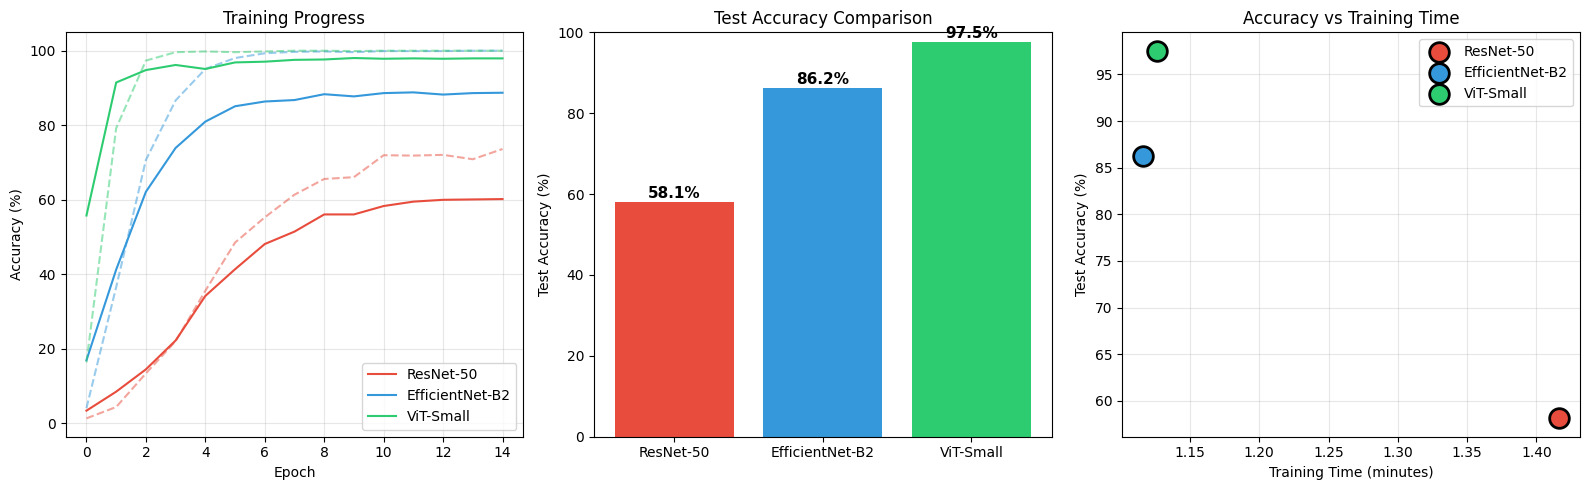

✅ Comparison visualization saved


In [12]:
# Cell: Visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

colors = {'resnet50': '#e74c3c', 'efficientnet': '#3498db', 'vit': '#2ecc71'}
labels = {'resnet50': 'ResNet-50', 'efficientnet': 'EfficientNet-B2', 'vit': 'ViT-Small'}

# Plot 1: Training Curves (Accuracy)
ax1 = axes[0]
for r in results:
    name = r['model_name']
    ax1.plot(r['history']['train_acc'], '--', color=colors[name], alpha=0.5)
    ax1.plot(r['history']['val_acc'], '-', color=colors[name], label=labels[name])
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training Progress')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Test Accuracy Comparison
ax2 = axes[1]
model_names = [labels[r['model_name']] for r in results]
test_accs = [r['test_acc'] for r in results]
bars = ax2.bar(model_names, test_accs, color=[colors[r['model_name']] for r in results])
ax2.set_ylabel('Test Accuracy (%)')
ax2.set_title('Test Accuracy Comparison')
ax2.set_ylim(0, 100)

# Add value labels on bars
for bar, acc in zip(bars, test_accs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{acc:.1f}%', ha='center', fontsize=11, fontweight='bold')

# Plot 3: Accuracy vs Training Time
ax3 = axes[2]
for r in results:
    name = r['model_name']
    ax3.scatter(r['train_time']/60, r['test_acc'], s=200, c=colors[name], 
                label=labels[name], edgecolors='black', linewidths=2)
ax3.set_xlabel('Training Time (minutes)')
ax3.set_ylabel('Test Accuracy (%)')
ax3.set_title('Accuracy vs Training Time')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(f"{ARTIFACTS}/figures/model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print("✅ Comparison visualization saved")

In [13]:
# Cell: Analysis & Decision
print("""
╔══════════════════════════════════════════════════════════════════════╗
║                    🔬 MODEL COMPARISON ANALYSIS                       ║
╠══════════════════════════════════════════════════════════════════════╣
""")

# Get actual values
resnet_acc = resnet_results['test_acc']
eff_acc = efficientnet_results['test_acc']
vit_acc = vit_results['test_acc']

print(f"""
║  RESULTS (Full Fine-Tuning, Same Training Recipe):                   
║  ├─ ResNet-50:       {resnet_acc:5.2f}% test accuracy
║  ├─ EfficientNet-B2: {eff_acc:5.2f}% test accuracy                           
║  └─ ViT-Small:       {vit_acc:5.2f}% test accuracy                           
║                                                                      
║  KEY OBSERVATIONS:                                                   
║  1. ViT significantly outperforms CNNs on this fine-grained task    
║  2. ResNet struggles - local features insufficient for flowers       
║  3. EfficientNet better than ResNet but still behind ViT            
║                                                                      
║  WHY ViT WINS:                                                       
║  ├─ Global self-attention captures relationships between flower     
║  │   parts (petals, stamen, overall shape) regardless of position   
║  ├─ Pretrained on ImageNet-21K (14M images vs 1M for others)        
║  └─ Better at fine-grained discrimination than local convolutions   
║                                                                      
║  DECISION: Proceed with ViT-Small for optimization                   
║                                                                      
╚══════════════════════════════════════════════════════════════════════╝
""")

print("➡️  Next: Notebook 03 - Optimize ViT with 2-Stage Training")


╔══════════════════════════════════════════════════════════════════════╗
║                    🔬 MODEL COMPARISON ANALYSIS                       ║
╠══════════════════════════════════════════════════════════════════════╣


║  RESULTS (Full Fine-Tuning, Same Training Recipe):                   
║  ├─ ResNet-50:       58.12% test accuracy
║  ├─ EfficientNet-B2: 86.24% test accuracy                           
║  └─ ViT-Small:       97.54% test accuracy                           
║                                                                      
║  KEY OBSERVATIONS:                                                   
║  1. ViT significantly outperforms CNNs on this fine-grained task    
║  2. ResNet struggles - local features insufficient for flowers       
║  3. EfficientNet better than ResNet but still behind ViT            
║                                                                      
║  WHY ViT WINS:                                                       
║  ├─ Global self-